In [17]:
!pip install dm-haiku
!pip install jax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import jax
from jax import lax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import haiku as hk
import scipy as sp
import functools

Instantiate a MLP Haiku Module

In [19]:
class MLP(hk.Module):
  def __init__(self, depth, hidden_size, out_dim, name='SimpleNet'):
    super(MLP, self).__init__(name=name)
    self._depth = depth
    self._hidden_size = hidden_size
    self._out_dim = out_dim
    layers = []
    for i in range(self._depth):
      layers.append(hk.Linear(self._hidden_size, name='linear_%d'%(i)))
    self._layers = layers
    self._final_layer = hk.Linear(self._out_dim, name='final_layer')

  def __call__(self, input):
    h = input
    for i in range(self._depth):
      h = jax.nn.relu(self._layers[i](h))
    return self._final_layer(h)

Generate "Real" Data

In [20]:
def real_data(batch_size):
  mog_mean = np.array([
        [ 2.35,  0.77],
        [ 0.77,  0.50],
        [ 4.43, -7.82],
        [ 7.82, -2.35],
        [ 0.77,  4.43],
        [ 7.82,  2.35],
        [ 0.77, -0.50],
        [ 7.82, -4.43],
        [-4.43,  2.35],
        [-2.35,  0.77],
        [-1.50, -0.50],
        [-1.50, -1.50],
        [-7.82,  4.43],
        [-2.35,  0.77],
        [-4.43, -7.82],
        [-0.77, -1.50],
    ])
  temp = np.tile(mog_mean, (batch_size // 16 + 1,1))
  mus = temp[0:batch_size,:]
  return mus + 0.02 * np.random.normal(size=(batch_size, 2))

Numerical Methods for ODEs

In [21]:
def euler_step(func, y0, f0, t0, dt):
  # Euler update
  y1 = jax.tree_map(lambda u, v: dt * v + u, y0, f0)
  return y1

def euler_heun_step(func, y0, f0, t0, dt):
  # RK2 Butcher tableaux
  alpha = jnp.array([1. / 2., 0.])
  beta = jnp.array([
      [1 / 2, 0,],
  ])
  c_sol = jnp.array([1 / 2, 1 / 2])

  def body_fun(i, k):
    ti = t0 + dt * alpha[i-1]
    yi = jax.tree_map(lambda u, v: u + dt * jnp.tensordot(beta[i-1, :], v, axes=1), y0, k)
    ft = func(yi, ti)
    return jax.tree_map(lambda x, y: x.at[i, :].set(y), k, ft)
  k = jax.tree_map(lambda f: jnp.zeros((2,) + f.shape,
                                       f.dtype).at[0, :].set(f), f0)
  k = lax.fori_loop(1, 2, body_fun, k)

  y1 = jax.tree_map(lambda u, v: dt * jnp.tensordot(c_sol, v, axes=1) + u, y0, k)
  return y1

def runge_kutta_step(func, y0, f0, t0, dt):
  # RK4 Butcher tableaux
  alpha = jnp.array([1. / 2., 1. / 2.,  1., 0])
  beta = jnp.array([
      [1. / 2., 0, 0, 0],
      [0, 1. / 2., 0, 0],
      [0, 0, 1., 0],
  ])
  c_sol = jnp.array([1. / 6., 1. / 3., 1. / 3., 1. / 6.])

  def body_fun(i, k):
    ti = t0 + dt * alpha[i-1]
    yi = jax.tree_map(lambda u, v: u + dt * jnp.tensordot(beta[i-1, :], v, axes=1), y0, k)
    ft = func(yi, ti)
    return jax.tree_map(lambda x, y: x.at[i, :].set(y), k, ft)
  k = jax.tree_map(lambda f: jnp.zeros((4,) + f.shape,
                                       f.dtype).at[0, :].set(f), f0)
  k = lax.fori_loop(1, 4, body_fun, k)

  y1 = jax.tree_map(lambda u, v: dt * jnp.tensordot(c_sol, v, axes=1) + u, y0, k)
  return y1

Extra Helper Functions-

In [22]:
def disc_loss(disc_params, gen_params, real_examples, latents):
  fake_examples = gen_model.apply(gen_params, None, latents)
  real_logits  = disc_model.apply(disc_params, None, real_examples)
  fake_logits = disc_model.apply(disc_params, None, fake_examples)
  disc_real = real_logits - jax.nn.log_sigmoid(real_logits)
  disc_fake = - jax.nn.log_sigmoid(fake_logits)
  return - jnp.mean(disc_real + disc_fake)

def gen_loss(disc_params, gen_params, real_examples, latents):
  fake_examples = gen_model.apply(gen_params, None, latents)
  fake_logits = disc_model.apply(disc_params, None, fake_examples)
  disc_fake = fake_logits - jax.nn.log_sigmoid(fake_logits)
  return - jnp.mean(disc_fake)

def gen_norm(disc_params, gen_params, real_examples, latents):
    grad = jax.grad(gen_loss, argnums=1)(
      disc_params, gen_params, real_examples, latents)
    flat, _ = jax.tree_flatten(grad)
    norm = 0.
    for a in flat:
      norm += jnp.sum(a * a)
    return - norm

def get_gen_grad(gen_params, t, disc_params, real_examples, latents):
  return jax.grad(gen_loss, argnums=1)(
      disc_params, gen_params, real_examples, latents)

def get_disc_grad(disc_params, t, gen_params, real_examples, latents):
  return jax.grad(disc_loss, argnums=0)(
      disc_params, gen_params, real_examples, latents)

Data Visualization

In [23]:
def kde(mu, tau, contours=None, bbox=None, xlabel="", ylabel="", cmap='Blues', st=0):
    values = np.vstack([mu, tau])
    kernel = sp.stats.gaussian_kde(values)

    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_aspect(abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks([])
    ax.set_yticks([])

    xx, yy = np.mgrid[bbox[0]:bbox[1]:300j, bbox[2]:bbox[3]:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    f = np.reshape(kernel(positions).T, xx.shape)
    cfset = ax.contourf(xx, yy, f, cmap=cmap)
    if contours is not None:
      x = np.arange(-2., 2., 0.1)
      y = np.arange(-2., 2., 0.1)
      cx, cy = np.meshgrid(x, y)
      new_set = ax.contour(cx, cy, contours.squeeze().reshape(cx.shape), levels=20, colors='k', linewidths=0.8, alpha=0.5)  
    plt.tight_layout()
    plt.show()

Integration

/usr/local/lib/python3.7/dist-packages/haiku/_src/base.py:497: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: jax.tree_flatten is deprecated

i = 0, discriminant loss = 1.3444555, generator loss = 0.65481293


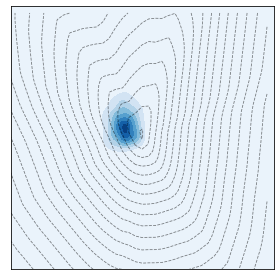

i = 2000, discriminant loss = 1.1269777, generator loss = 0.84580886


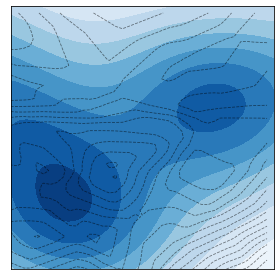

i = 4000, discriminant loss = 1.2211607, generator loss = 0.6724901


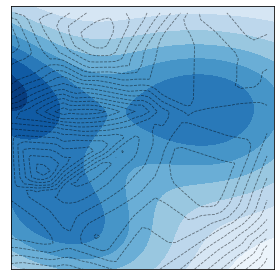

i = 6000, discriminant loss = 1.2202828, generator loss = 0.7049322


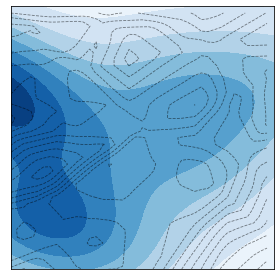

i = 8000, discriminant loss = 1.2671489, generator loss = 0.69379


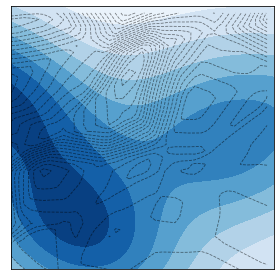

In [24]:
n_itrs = 10000 #@param {type : 'integer'}
n_save = 2000 #@param {type : 'integer'}
latent_size = 32 #@param {type : 'integer'}
bs = 512 #@param {type : 'integer'}
odeint = 'runge_kutta_step' #@param ['euler_step', 'euler_heun_step', 'runge_kutta_step'] {type : 'string'}
delta_t = 0.23 #@param {type : 'number'}
reg_param = 0.19 #@param {type : 'number'}

def forward_disc(batch):
  disc_model = MLP(2, 25, 1)
  return disc_model(batch)

def forward_gen(batch):
  gen_model = MLP(2, 25, 2)
  return gen_model(batch)


disc_model = hk.transform(forward_disc)
gen_model = hk.transform(forward_gen)
real_examples = real_data(bs)

ODEINT = {'runge_kutta_step': runge_kutta_step, 
          'euler_heun_step': euler_heun_step,
          'euler_step': euler_step}
@jax.jit
def ode_update(i, disc_params, gen_params, real_examples, latents):
  dloss, disc_grad = jax.value_and_grad(disc_loss, argnums=0)(
      disc_params, gen_params, real_examples, latents)
  gloss, gen_grad = jax.value_and_grad(gen_loss, argnums=1)(
      disc_params, gen_params, real_examples, latents)
  disc_gen_grad = jax.grad(gen_norm, argnums=0)(
      disc_params, gen_params, real_examples, latents)
  grad_disc_fn = functools.partial(get_disc_grad,
                                   **{'gen_params' : gen_params,
                                      'real_examples' : real_examples,
                                      'latents' : latents})
  grad_gen_fn = functools.partial(get_gen_grad, 
                                  **{'disc_params' : disc_params,
                                     'real_examples' : real_examples,
                                     'latents' : latents})  
  new_gen_params = ODEINT[odeint](
      grad_gen_fn, gen_params, gen_grad, 0., delta_t)
  new_disc_params = ODEINT[odeint](
      grad_disc_fn, disc_params, disc_grad, 0., delta_t)
  new_disc_params = jax.tree_map(
      lambda x, y: x + delta_t * reg_param * y, new_disc_params, disc_gen_grad)
  return new_disc_params, new_gen_params, -dloss, -gloss

rng = jax.random.PRNGKey(np.random.randint(low=0, high=int(1e7)))
test_latents = np.random.normal(size=(bs * 10, latent_size))
latents = np.random.normal(size=(bs, latent_size))
disc_params = disc_model.init(rng, real_examples)
gen_params = gen_model.init(
    jax.random.PRNGKey(np.random.randint(low=0, high=int(1e7))), latents)

x = np.arange(-2., 2., 0.1)
y = np.arange(-2., 2., 0.1)
X, Y = np.meshgrid(x, y)
pairs = np.stack((X, Y), axis=-1)
pairs = np.reshape(pairs, (-1, 2))

for e in range(n_itrs):
  real_examples = real_data(bs)
  latents = np.random.normal(size=(bs, latent_size))

  (disc_params, gen_params,
   dloss, gloss) = ode_update(e, disc_params, gen_params, real_examples, latents)
   
  if e % n_save == 0:
    real_logits = disc_model.apply(disc_params, None, pairs)
    disc_contour = - real_logits + jax.nn.log_sigmoid(real_logits)
    print('i = %d, discriminant loss = %s, generator loss = %s' %
          (e, dloss, gloss))
    bbox = [-2, 2, -2, 2]
    fake_examples = gen_model.apply(gen_params, None, test_latents)
    kde(fake_examples[:, 0], fake_examples[:, 1], contours=disc_contour, bbox=bbox, st=e)
    disc_error = 0
    gen_error = 0